In [1]:
import copy
import os.path as osp
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cmap = plt.get_cmap('cubehelix')
indices = np.linspace(0, cmap.N, 10)
my_colors = [cmap(int(i)) for i in indices]

sys.path.insert(0, "../src/")

In [2]:
# Plot params
mpl.style.use("seaborn-dark")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["figure.dpi"] = 85
mpl.rcParams["axes.labelsize"] = "large"
mpl.rcParams["lines.linestyle"] = "-."
mpl.rcParams["lines.marker"] = "o"
mpl.rcParams["lines.markersize"] = 2
mpl.rcParams["lines.linewidth"] = 1.8

# This is the largest possible value of the logloss
logloss_inf_limit = -np.log(np.finfo("float").eps)

In [4]:
res_paths = [
    osp.join("..", "output", "uci_experiment_20201101_081152", "results.csv"),
    osp.join("..", "output", "uci_experiment_20201101_091125", "results.csv"),
    osp.join("..", "output", "uci_experiment_20201101_091152", "results.csv"),
    osp.join("..", "output", "uci_experiment_20201101_091155", "results.csv"),
    osp.join("..", "output", "uci_experiment_20201101_111152", "results.csv"),
]

res_paths = [
    osp.join("..", "output", "uci_experiment_bostonHousing_20201110_111128", "results.csv"),
    osp.join("..", "output", "uci_experiment_concrete_20201110_121120", "results.csv"),
    osp.join("..", "output", "uci_experiment_energy_20201110_131107", "results.csv"),
    osp.join("..", "output", "uci_experiment_kin8nm_20201110_131130", "results.csv"),
#     osp.join("..", "output", "uci_experiment_naval-propulsion-plant_20201110_171151", "results.csv"),
    osp.join("..", "output", "uci_experiment_power-plant_20201110_171156", "results.csv"),
    osp.join("..", "output", "uci_experiment_wine-quality-red_20201110_181111", "results.csv"),
    osp.join("..", "output", "uci_experiment_yacht_20201110_201101", "results.csv"),
]

res_dfs = [pd.read_csv(res_path) for res_path in res_paths]

In [5]:
# Take the mean over experimetns
res_list = []
for res_df in res_dfs:
    dataset_name = res_df.dataset_name.unique()
    assert len(dataset_name) == 1
    dataset_name = dataset_name[0]

    # Filter samples that the pNML was not converged there from empirical reasons
    print(f'{dataset_name} Failure: ', (res_df["empirical_pnml_success"] == False).sum())
    res_df = res_df[res_df["empirical_pnml_success"] == True]
    res_df = res_df[res_df.trainset_size > 3]

    print(
        f"{dataset_name}. \t num_featues={res_df.num_features.mean()}. trainset sizes={res_df.trainset_size.unique()}"
    )
    res_mean_df = res_df.groupby("trainset_size").mean().reset_index()
    res_std_df = res_df.groupby("trainset_size").agg(np.std, ddof=0).reset_index()
    res_count_df = res_df.groupby("trainset_size").agg("count")

    res_list.append(
        {
            "dataset_name": dataset_name,
            "mean_df": res_mean_df,
            "std_df": res_std_df,
            "count_df": res_count_df,
            "res_df": res_df
        }
    )

bostonHousing Failure:  0
bostonHousing. 	 num_featues=14.0. trainset sizes=[  4   5   6   7   8   9  10  11  12  13  14  15  21  31  45  65  94 135
 196 283 409]
concrete Failure:  0
concrete. 	 num_featues=9.0. trainset sizes=[  4   5   6   7   8   9  10  16  26  43  71 116 190 312 510 834]
energy Failure:  0
energy. 	 num_featues=9.0. trainset sizes=[  4   5   6   7   8   9  10  15  25  39  62  99 156 248 392 620]
kin8nm Failure:  0
kin8nm. 	 num_featues=9.0. trainset sizes=[   4    5    6    7    8    9   10   20   42   87  179  369  760 1565
 3223 6634]
power-plant Failure:  39514
power-plant. 	 num_featues=5.0. trainset sizes=[   4    5    6   13   29   65  144  321  711 1577 3495 7749]
wine-quality-red Failure:  0
wine-quality-red. 	 num_featues=12.0. trainset sizes=[   4    5    6    7    8    9   10   11   12   21   36   60  100  167
  279  465  776 1295]
yacht Failure:  0
yacht. 	 num_featues=7.0. trainset sizes=[  4   5   6   7  11  17  25  36  54  79 115 169 249]


In [6]:
def plot_confidence_interval(ax, mean, std, count, color: str):
    mean, std, count = np.array(mean), np.array(std), np.array(count)
    lower = mean - 1.960 * std / np.sqrt(count)
    upper = mean + 1.960 * std / np.sqrt(count)
    ax.fill_between(trainset_size, upper, lower, color=color, alpha=0.2)  # std curves

bostonHousing


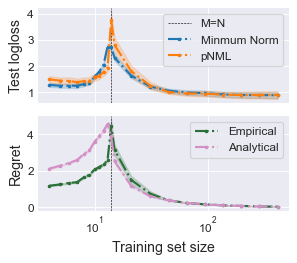

concrete


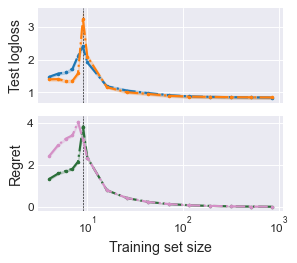

energy


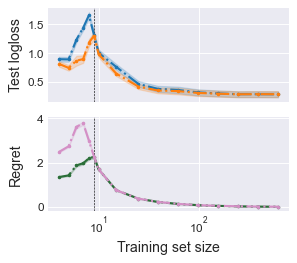

kin8nm


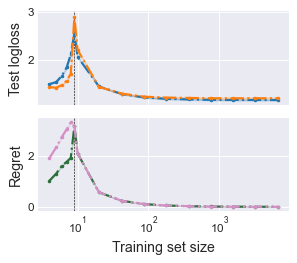

power-plant


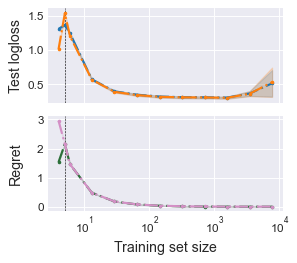

wine-quality-red


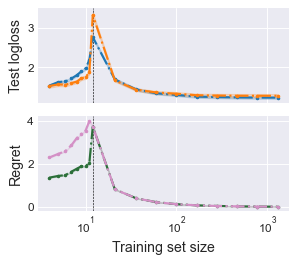

yacht


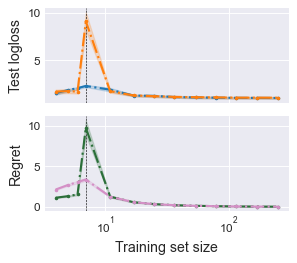

In [7]:
# Plot performence
for i, res_dict in enumerate(res_list):
    dataset_name = res_dict["dataset_name"]
    res_mean_df = res_dict["mean_df"]
    res_std_df = res_dict["std_df"]
    res_count_df = res_dict["count_df"]

    print(dataset_name)

    w, h = plt.rcParams.get("figure.figsize")
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(0.6*w, 0.8*h))

    axs[0].axvline(
        res_mean_df["num_features"].mean(),
        color="black",
        linewidth=0.5,
        linestyle="--",
        marker="",
        label="M=N",
    )
    axs[1].axvline(
        res_mean_df["num_features"].mean(),
        color="black",
        linewidth=0.5,
        linestyle="--",
        marker="",
    )

    ax = axs[0]
    trainset_size = res_mean_df["trainset_size"]
    ax.plot(trainset_size, res_mean_df["mn_test_logloss"], label="Minmum Norm")
    #     ax.plot(trainset_size, res_mean_df["mdl_test_logloss"], label="MDL")
    ax.plot(
        trainset_size, res_mean_df["empirical_pnml_test_logloss"], label="pNML",
    )

    key = "mn_test_logloss"
    plot_confidence_interval(
        ax, res_mean_df[key], res_std_df[key], res_count_df[key], "C0"
    )
    #     key = "mdl_test_logloss"
    #     plot_confidence_interval(
    #         ax, res_mean_df[key], res_std_df[key], res_count_df[key], "C1"
    #     )
    key = "empirical_pnml_test_logloss"
    plot_confidence_interval(
        ax, res_mean_df[key], res_std_df[key], res_count_df[key], "C1"
    )
    
    if i ==0:
        ax.legend(loc=1)
    ax.set_ylabel("Test logloss")

    ax = axs[1]
    ax.plot(
        trainset_size,
        res_mean_df["empirical_pnml_regret"],
        label="Empirical",
        color=my_colors[3]
    )
    ax.plot(
        trainset_size,
        res_mean_df["analytical_pnml_regret"],
        label="Analytical",
        color=my_colors[-4]
    )
    
    key = "empirical_pnml_regret"
    plot_confidence_interval(
        ax, res_mean_df[key], res_std_df[key], res_count_df[key], my_colors[3],
    )
    key = "analytical_pnml_regret"
    plot_confidence_interval(
        ax, res_mean_df[key], res_std_df[key], res_count_df[key],  my_colors[-4],
    )
    
    if i ==0:
        ax.legend(loc=1)
    ax.set_ylabel("Regret")
    ax.set_xlabel("Training set size")

    plt.xscale("symlog")
    # plt.yscale('symlog')
    fig.align_ylabels(axs)
    plt.tight_layout()
    plt.savefig(f"../output/figures/real_data_{dataset_name}.pdf")
    plt.show()

In [8]:
res_dict = res_list[0]
res_df,dataset_name= res_dict['res_df'],res_dict['dataset_name']
trainset_size = 10
trail_num= 0 
print(res_df.trainset_size.unique())
df = res_df[res_df.trainset_size == trainset_size]
print(df.columns)

[  4   5   6   7   8   9  10  11  12  13  14  15  21  31  45  65  94 135
 196 283 409]
Index(['dataset_name', 'trainset_size', 'trail_num', 'valset_size',
       'testset_size', 'num_features', 'mn_test_logloss', 'mn_test_mse',
       'mn_theta_norm', 'mn_variance', 'empirical_pnml_regret',
       'empirical_pnml_test_logloss', 'empirical_pnml_variance',
       'empirical_pnml_success', 'analytical_pnml_regret', 'genie_test_mse',
       'genie_test_logloss', 'genie_theta_norm', 'genie_variance', 'test_idx'],
      dtype='object')


Text(0, 0.5, 'logloss')

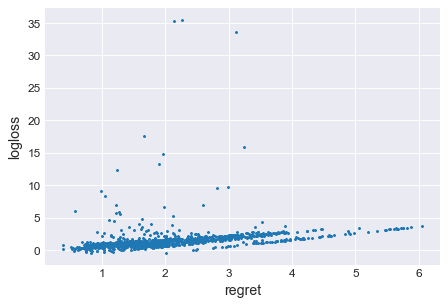

In [9]:
df = df.sort_values(by='empirical_pnml_regret')
plt.plot(df.empirical_pnml_regret,df.empirical_pnml_test_logloss,'*')
plt.xlabel('regret')
plt.ylabel('logloss')

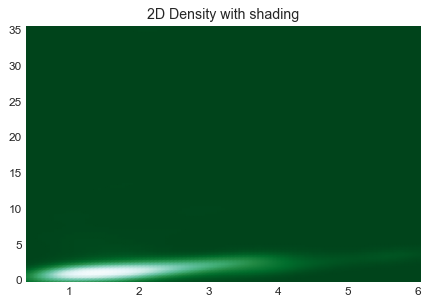

In [10]:
from scipy.stats import kde
nbins = 100
x,y = df.empirical_pnml_regret,df.empirical_pnml_test_logloss
data = np.array((x, y)).T

fig,ax = plt.subplots(1,1)

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 

# add shading
ax.set_title('2D Density with shading')
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)


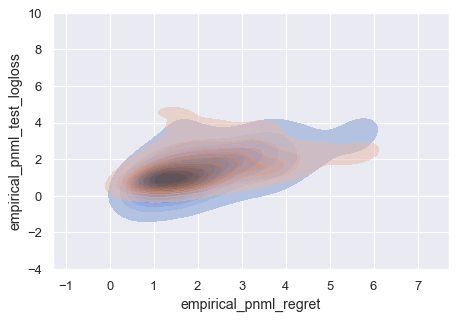

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# fig,ax = plt.subplots(1,1)
# sns.jointplot(data=df, x="empirical_pnml_regret", y="empirical_pnml_test_logloss",kind="kde")
# sns.jointplot(data=df, x="empirical_pnml_regret", y="mn_test_logloss",kind="kde")
# ax.set_ylim(top=10)
# plt.show()

fig,ax = plt.subplots(1,1)
sns.kdeplot(data=df, x="empirical_pnml_regret", y="empirical_pnml_test_logloss", shade=True, cut=5, ax=ax)
sns.kdeplot(data=df, x="empirical_pnml_regret", y="mn_test_logloss", shade=True, cut=5, ax=ax,alpha=0.5)
ax.set_ylim(top=10)
plt.show()